In [2]:
import sys
# sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# tf.enable_eager_execution()
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [10]:
class PhysicsInformedNN3:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub, q):
        
        self.loss_array= []
        self.lambda_array= []
        
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        self.q = q
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([1.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = (X - self.lb)/(self.ub - self.lb) 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.math.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        q = self.q 
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
#         f= q+ lambda_1*u_x
        f = q + lambda_1*(u_t) 
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, lambda_2))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                
                self.loss_array.append(loss_value)
                self.lambda_array.append(lambda_1_value)
#                 lolz= self.sess.run(self.net_f(self.x_tf,self.t_tf) , tf_dict)
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
#                 print(lolz)
                start_time = time.time()
        
#         self.optimizer_Adam.minimize(self.loss)
        
        
#         self.optimizer.minimize(self.sess,
#                                 feed_dict = tf_dict,
#                                 fetches = [self.loss, self.lambda_1, self.lambda_2],
#                                 loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star

In [3]:
df= pd.read_csv(r"C:\Users\Omkar\Downloads\NEW TEMP AND FLUX (XZ)_.csv")

In [4]:
df

,X Location (m),Z Location (m),Temperature (K),Heat Flux (W/mK),Unnamed: 4
0,1.00000,1.00000,1.00000,0.25,NaN
1,1.00000,0.00000,0.50004,0.25,NaN
2,1.00000,0.99500,0.99750,0.25,NaN
3,1.00000,0.99000,0.99500,0.25,NaN
4,1.00000,0.98500,0.99250,0.25,NaN
...,...,...,...,...,...
161599,-0.35000,-0.59000,0.20502,0.25,NaN
161600,-0.20000,-0.68000,0.16001,0.25,NaN
161601,-0.75000,-0.40000,0.30002,0.25,NaN
161602,-0.60000,-0.75000,0.12501,0.25,NaN


In [5]:
q=df.loc[:,["Heat Flux (W/mK)" ]] 

In [8]:
q_final=-np.array(q)

In [11]:
x_z=df.loc[:,["X Location (m)","Z Location (m)" ]] 

In [12]:
x_z=np.array(x_z)

In [13]:
u=df.loc[:,"Temperature (K)"]

In [14]:
u=np.array(u)

In [15]:
u=u.reshape(161604,1)

In [22]:
layers2 = [2, 20, 20, 20, 20, 1]

In [17]:
N_u=30


In [18]:
lb1 = x_z.min(0)
ub1 = x_z.max(0)

In [19]:
idx = np.random.choice(x_z.shape[0], N_u, replace=False)
X_u_train = x_z[idx,:]
u_train = u[idx,:]
q_= q_final[idx,:]
q_t= tf.convert_to_tensor(q_,dtype=tf.float32)

In [23]:
model = PhysicsInformedNN3(X_u_train, u_train, layers2, lb1, ub1 , q_t)
model.train(10000)

Device mapping:

It: 0, Loss: 8.333e-01, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.23
It: 10, Loss: 4.864e-01, Lambda_1: 0.011, Lambda_2: 1.000000, Time: 0.02
It: 20, Loss: 2.696e-01, Lambda_1: 0.021, Lambda_2: 1.000000, Time: 0.01
It: 30, Loss: 1.635e-01, Lambda_1: 0.031, Lambda_2: 1.000000, Time: 0.01
It: 40, Loss: 1.295e-01, Lambda_1: 0.041, Lambda_2: 1.000000, Time: 0.01
It: 50, Loss: 1.258e-01, Lambda_1: 0.051, Lambda_2: 1.000000, Time: 0.01
It: 60, Loss: 1.269e-01, Lambda_1: 0.062, Lambda_2: 1.000000, Time: 0.01
It: 70, Loss: 1.264e-01, Lambda_1: 0.073, Lambda_2: 1.000000, Time: 0.01
It: 80, Loss: 1.258e-01, Lambda_1: 0.085, Lambda_2: 1.000000, Time: 0.01
It: 90, Loss: 1.256e-01, Lambda_1: 0.097, Lambda_2: 1.000000, Time: 0.01
It: 100, Loss: 1.256e-01, Lambda_1: 0.109, Lambda_2: 1.000000, Time: 0.01
It: 110, Loss: 1.256e-01, Lambda_1: 0.122, Lambda_2: 1.000000, Time: 0.01
It: 120, Loss: 1.256e-01, Lambda_1: 0.135, Lambda_2: 1.000000, Time: 0.01
It: 130, Loss: 1.255e-01, Lambda

It: 1210, Loss: 2.350e-03, Lambda_1: 0.605, Lambda_2: 1.000000, Time: 0.01
It: 1220, Loss: 2.249e-03, Lambda_1: 0.599, Lambda_2: 1.000000, Time: 0.01
It: 1230, Loss: 2.155e-03, Lambda_1: 0.594, Lambda_2: 1.000000, Time: 0.01
It: 1240, Loss: 2.068e-03, Lambda_1: 0.589, Lambda_2: 1.000000, Time: 0.01
It: 1250, Loss: 1.988e-03, Lambda_1: 0.585, Lambda_2: 1.000000, Time: 0.01
It: 1260, Loss: 1.913e-03, Lambda_1: 0.581, Lambda_2: 1.000000, Time: 0.01
It: 1270, Loss: 1.844e-03, Lambda_1: 0.577, Lambda_2: 1.000000, Time: 0.01
It: 1280, Loss: 1.780e-03, Lambda_1: 0.573, Lambda_2: 1.000000, Time: 0.01
It: 1290, Loss: 1.720e-03, Lambda_1: 0.570, Lambda_2: 1.000000, Time: 0.01
It: 1300, Loss: 1.664e-03, Lambda_1: 0.567, Lambda_2: 1.000000, Time: 0.01
It: 1310, Loss: 1.612e-03, Lambda_1: 0.564, Lambda_2: 1.000000, Time: 0.01
It: 1320, Loss: 1.563e-03, Lambda_1: 0.561, Lambda_2: 1.000000, Time: 0.01
It: 1330, Loss: 1.518e-03, Lambda_1: 0.559, Lambda_2: 1.000000, Time: 0.01
It: 1340, Loss: 1.474e-03

It: 2390, Loss: 3.980e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 2400, Loss: 3.819e-05, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 2410, Loss: 3.666e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2420, Loss: 3.520e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2430, Loss: 3.381e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2440, Loss: 3.249e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2450, Loss: 3.124e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2460, Loss: 3.005e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2470, Loss: 2.892e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2480, Loss: 2.785e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2490, Loss: 2.684e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2500, Loss: 2.588e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2510, Loss: 2.497e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 2520, Loss: 2.410e-05

It: 3560, Loss: 6.249e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3570, Loss: 6.209e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3580, Loss: 6.168e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3590, Loss: 6.128e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3600, Loss: 6.088e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3610, Loss: 6.049e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3620, Loss: 6.010e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3630, Loss: 5.971e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3640, Loss: 5.933e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3650, Loss: 5.895e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3660, Loss: 5.857e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3670, Loss: 5.820e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3680, Loss: 5.783e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 3690, Loss: 5.747e-06

It: 4740, Loss: 3.042e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4750, Loss: 3.024e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4760, Loss: 3.005e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4770, Loss: 2.986e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4780, Loss: 2.967e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4790, Loss: 2.949e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4800, Loss: 2.930e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4810, Loss: 2.912e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4820, Loss: 2.894e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4830, Loss: 2.876e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4840, Loss: 2.857e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4850, Loss: 2.839e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4860, Loss: 2.822e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 4870, Loss: 2.804e-06

It: 5910, Loss: 1.307e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 5920, Loss: 1.467e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 5930, Loss: 1.312e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 5940, Loss: 1.441e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 5950, Loss: 1.339e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 5960, Loss: 1.254e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 5970, Loss: 1.245e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 5980, Loss: 1.233e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 5990, Loss: 1.219e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 6000, Loss: 1.209e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 6010, Loss: 1.198e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 6020, Loss: 1.188e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 6030, Loss: 1.177e-06, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.01
It: 6040, Loss: 1.167e-06

It: 7040, Loss: 4.490e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7050, Loss: 4.445e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7060, Loss: 4.400e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7070, Loss: 4.356e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7080, Loss: 4.312e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7090, Loss: 4.269e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7100, Loss: 4.225e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7110, Loss: 4.183e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7120, Loss: 4.141e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7130, Loss: 4.136e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7140, Loss: 7.737e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7150, Loss: 2.609e-06, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7160, Loss: 1.151e-06, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 7170, Loss: 4.185e-07

It: 8230, Loss: 1.452e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8240, Loss: 1.440e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8250, Loss: 1.433e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8260, Loss: 1.628e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8270, Loss: 1.920e-06, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8280, Loss: 5.337e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8290, Loss: 2.648e-06, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8300, Loss: 1.657e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8310, Loss: 3.856e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8320, Loss: 1.861e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8330, Loss: 1.576e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8340, Loss: 1.373e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8350, Loss: 1.375e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 8360, Loss: 1.312e-07

It: 9370, Loss: 6.916e-08, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9380, Loss: 6.882e-08, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9390, Loss: 6.848e-08, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9400, Loss: 6.813e-08, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9410, Loss: 6.781e-08, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9420, Loss: 6.756e-08, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9430, Loss: 7.131e-08, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9440, Loss: 3.989e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9450, Loss: 2.282e-05, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9460, Loss: 2.997e-06, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9470, Loss: 2.881e-06, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9480, Loss: 5.477e-07, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9490, Loss: 7.019e-08, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9500, Loss: 1.719e-07

In [24]:
arr=[]
for i in range(0,10000):
    if i%10==0:
        arr.append(i)

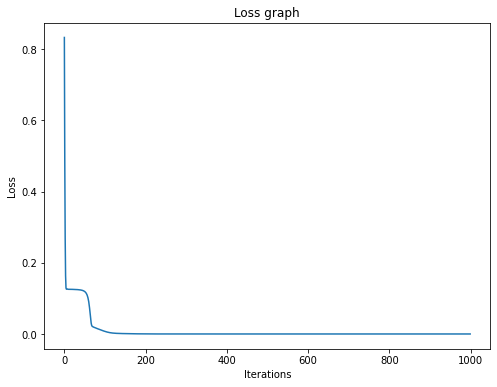

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

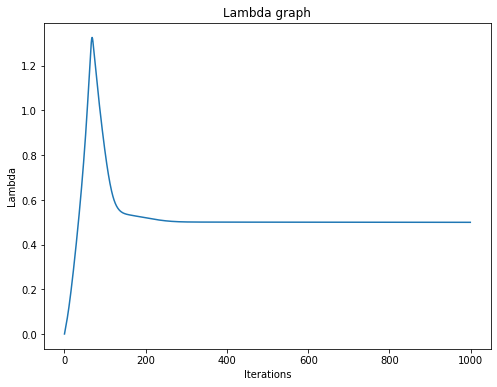

In [26]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [29]:
noise1 = 0.01        
u_train2 = u_train + noise1*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])



In [31]:
model2 = PhysicsInformedNN3(X_u_train, u_train2, layers2, lb1, ub1 , q_t)
model2.train(10000)

Device mapping:

It: 0, Loss: 1.341e-01, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.31
It: 10, Loss: 1.280e-01, Lambda_1: 0.011, Lambda_2: 1.000000, Time: 0.01
It: 20, Loss: 1.264e-01, Lambda_1: 0.022, Lambda_2: 1.000000, Time: 0.01
It: 30, Loss: 1.258e-01, Lambda_1: 0.033, Lambda_2: 1.000000, Time: 0.01
It: 40, Loss: 1.256e-01, Lambda_1: 0.045, Lambda_2: 1.000000, Time: 0.01
It: 50, Loss: 1.255e-01, Lambda_1: 0.058, Lambda_2: 1.000000, Time: 0.01
It: 60, Loss: 1.255e-01, Lambda_1: 0.071, Lambda_2: 1.000000, Time: 0.01
It: 70, Loss: 1.254e-01, Lambda_1: 0.085, Lambda_2: 1.000000, Time: 0.01
It: 80, Loss: 1.253e-01, Lambda_1: 0.100, Lambda_2: 1.000000, Time: 0.01
It: 90, Loss: 1.251e-01, Lambda_1: 0.116, Lambda_2: 1.000000, Time: 0.01
It: 100, Loss: 1.250e-01, Lambda_1: 0.132, Lambda_2: 1.000000, Time: 0.01
It: 110, Loss: 1.248e-01, Lambda_1: 0.148, Lambda_2: 1.000000, Time: 0.01
It: 120, Loss: 1.245e-01, Lambda_1: 0.166, Lambda_2: 1.000000, Time: 0.01
It: 130, Loss: 1.242e-01, Lambda

It: 1190, Loss: 1.494e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1200, Loss: 1.486e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1210, Loss: 1.478e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1220, Loss: 1.470e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1230, Loss: 1.461e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1240, Loss: 1.453e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1250, Loss: 1.445e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1260, Loss: 1.437e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1270, Loss: 1.429e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1280, Loss: 1.421e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1290, Loss: 1.413e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1300, Loss: 1.405e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1310, Loss: 1.398e-04, Lambda_1: 0.510, Lambda_2: 1.000000, Time: 0.01
It: 1320, Loss: 1.398e-04

It: 2350, Loss: 8.882e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2360, Loss: 8.515e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2370, Loss: 9.061e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2380, Loss: 8.739e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2390, Loss: 8.505e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2400, Loss: 8.377e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2410, Loss: 8.321e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2420, Loss: 8.294e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2430, Loss: 8.261e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2440, Loss: 8.229e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2450, Loss: 8.199e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2460, Loss: 8.168e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2470, Loss: 8.138e-05, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2480, Loss: 8.108e-05

It: 3520, Loss: 1.387e-04, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3530, Loss: 7.954e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3540, Loss: 6.560e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3550, Loss: 6.112e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3560, Loss: 5.924e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3570, Loss: 5.843e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3580, Loss: 5.805e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3590, Loss: 5.785e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3600, Loss: 5.771e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3610, Loss: 5.756e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3620, Loss: 5.740e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3630, Loss: 5.726e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3640, Loss: 5.711e-05, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 3650, Loss: 5.696e-05

It: 4650, Loss: 4.536e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4660, Loss: 4.526e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4670, Loss: 4.517e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4680, Loss: 4.507e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4690, Loss: 4.498e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4700, Loss: 4.489e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4710, Loss: 4.479e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4720, Loss: 4.470e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4730, Loss: 4.460e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4740, Loss: 4.451e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4750, Loss: 4.441e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4760, Loss: 4.432e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4770, Loss: 4.423e-05, Lambda_1: 0.506, Lambda_2: 1.000000, Time: 0.01
It: 4780, Loss: 4.426e-05

It: 5860, Loss: 3.652e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5870, Loss: 3.646e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5880, Loss: 3.640e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5890, Loss: 3.633e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5900, Loss: 3.630e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5910, Loss: 4.147e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5920, Loss: 5.915e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5930, Loss: 5.817e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5940, Loss: 4.360e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5950, Loss: 3.845e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5960, Loss: 3.684e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5970, Loss: 3.629e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5980, Loss: 3.603e-05, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 5990, Loss: 3.587e-05

It: 7090, Loss: 3.075e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7100, Loss: 3.071e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7110, Loss: 3.067e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7120, Loss: 3.063e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7130, Loss: 3.059e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7140, Loss: 3.055e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7150, Loss: 3.051e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7160, Loss: 3.047e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7170, Loss: 3.043e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7180, Loss: 3.039e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7190, Loss: 3.035e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7200, Loss: 3.031e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7210, Loss: 3.027e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 7220, Loss: 3.060e-05

It: 8310, Loss: 2.678e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8320, Loss: 2.675e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8330, Loss: 2.672e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8340, Loss: 2.670e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8350, Loss: 2.668e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8360, Loss: 2.884e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8370, Loss: 1.356e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8380, Loss: 3.500e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8390, Loss: 2.682e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8400, Loss: 2.662e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8410, Loss: 2.683e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8420, Loss: 2.685e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8430, Loss: 2.666e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 8440, Loss: 2.648e-05

It: 9460, Loss: 2.403e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9470, Loss: 2.401e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9480, Loss: 2.399e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9490, Loss: 2.396e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9500, Loss: 2.394e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9510, Loss: 2.392e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9520, Loss: 2.391e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9530, Loss: 3.035e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9540, Loss: 2.842e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 9550, Loss: 2.452e-05, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 9560, Loss: 2.746e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9570, Loss: 2.817e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9580, Loss: 2.504e-05, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 9590, Loss: 2.389e-05

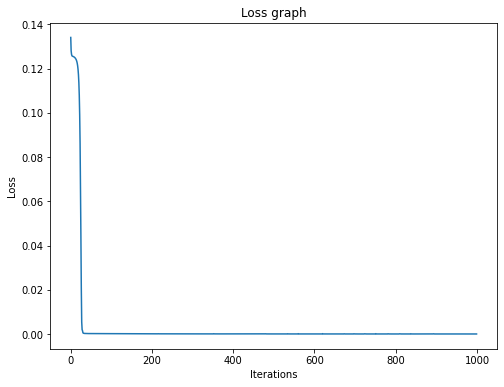

In [32]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model2.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

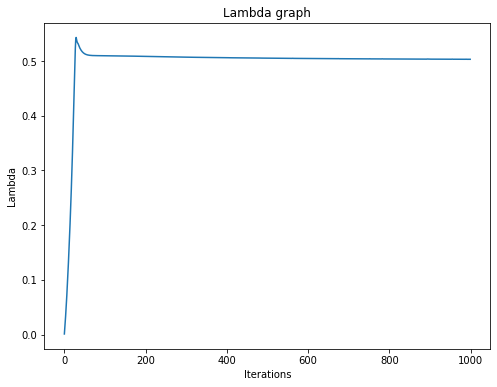

In [33]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model2.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [34]:
noise3 = 0.05    
u_train3 = u_train + noise3*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

In [35]:
model3 = PhysicsInformedNN3(X_u_train, u_train3, layers2, lb1, ub1 , q_t)
model3.train(10000)

Device mapping:

It: 0, Loss: 1.595e-01, Lambda_1: -0.001, Lambda_2: 1.000000, Time: 0.29
It: 10, Loss: 1.301e-01, Lambda_1: -0.011, Lambda_2: 1.000000, Time: 0.01
It: 20, Loss: 1.275e-01, Lambda_1: -0.020, Lambda_2: 1.000000, Time: 0.01
It: 30, Loss: 1.278e-01, Lambda_1: -0.028, Lambda_2: 1.000000, Time: 0.01
It: 40, Loss: 1.268e-01, Lambda_1: -0.034, Lambda_2: 1.000000, Time: 0.01
It: 50, Loss: 1.268e-01, Lambda_1: -0.037, Lambda_2: 1.000000, Time: 0.01
It: 60, Loss: 1.268e-01, Lambda_1: -0.036, Lambda_2: 1.000000, Time: 0.01
It: 70, Loss: 1.267e-01, Lambda_1: -0.030, Lambda_2: 1.000000, Time: 0.01
It: 80, Loss: 1.267e-01, Lambda_1: -0.019, Lambda_2: 1.000000, Time: 0.01
It: 90, Loss: 1.266e-01, Lambda_1: -0.005, Lambda_2: 1.000000, Time: 0.01
It: 100, Loss: 1.266e-01, Lambda_1: 0.011, Lambda_2: 1.000000, Time: 0.01
It: 110, Loss: 1.266e-01, Lambda_1: 0.029, Lambda_2: 1.000000, Time: 0.01
It: 120, Loss: 1.265e-01, Lambda_1: 0.047, Lambda_2: 1.000000, Time: 0.01
It: 130, Loss: 1.264e-

It: 1280, Loss: 3.040e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1290, Loss: 3.018e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1300, Loss: 2.997e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1310, Loss: 2.975e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1320, Loss: 2.954e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1330, Loss: 2.932e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1340, Loss: 2.911e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1350, Loss: 2.890e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1360, Loss: 2.870e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1370, Loss: 2.849e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1380, Loss: 2.829e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1390, Loss: 2.809e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1400, Loss: 2.789e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 1410, Loss: 2.769e-04

It: 2540, Loss: 1.438e-04, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 2550, Loss: 1.450e-04, Lambda_1: 0.505, Lambda_2: 1.000000, Time: 0.01
It: 2560, Loss: 1.428e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 2570, Loss: 1.433e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 2580, Loss: 1.414e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 2590, Loss: 1.410e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 2600, Loss: 1.403e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 2610, Loss: 1.398e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 2620, Loss: 1.392e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 2630, Loss: 1.387e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 2640, Loss: 1.381e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 2650, Loss: 1.376e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 2660, Loss: 1.370e-04, Lambda_1: 0.504, Lambda_2: 1.000000, Time: 0.01
It: 2670, Loss: 1.365e-04

It: 3800, Loss: 1.031e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 3810, Loss: 1.026e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 3820, Loss: 1.022e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 3830, Loss: 1.021e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 3840, Loss: 1.020e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 3850, Loss: 1.019e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 3860, Loss: 1.018e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 3870, Loss: 1.017e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 3880, Loss: 1.016e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.01
It: 3890, Loss: 1.015e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 3900, Loss: 1.014e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 3910, Loss: 1.013e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 3920, Loss: 1.012e-04, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 3930, Loss: 1.011e-04

It: 4910, Loss: 9.765e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 4920, Loss: 9.763e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 4930, Loss: 9.767e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 4940, Loss: 9.757e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 4950, Loss: 9.755e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 4960, Loss: 9.754e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 4970, Loss: 9.753e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 4980, Loss: 9.752e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 4990, Loss: 9.751e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 5000, Loss: 9.751e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 5010, Loss: 9.750e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 5020, Loss: 9.749e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 5030, Loss: 9.749e-05, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 5040, Loss: 9.748e-05

It: 6020, Loss: 9.722e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6030, Loss: 9.721e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6040, Loss: 9.721e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6050, Loss: 9.721e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6060, Loss: 9.721e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6070, Loss: 9.721e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6080, Loss: 9.721e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6090, Loss: 9.721e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6100, Loss: 9.721e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6110, Loss: 9.720e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6120, Loss: 9.720e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6130, Loss: 9.720e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6140, Loss: 9.732e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 6150, Loss: 1.195e-04

It: 7120, Loss: 9.711e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7130, Loss: 9.710e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7140, Loss: 9.710e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7150, Loss: 9.710e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7160, Loss: 9.710e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7170, Loss: 9.710e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7180, Loss: 9.710e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7190, Loss: 9.710e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7200, Loss: 9.710e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7210, Loss: 9.710e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7220, Loss: 9.710e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7230, Loss: 9.709e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7240, Loss: 9.709e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 7250, Loss: 9.709e-05

It: 8390, Loss: 9.730e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8400, Loss: 9.705e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8410, Loss: 9.697e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8420, Loss: 9.697e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8430, Loss: 9.697e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8440, Loss: 9.696e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8450, Loss: 9.696e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8460, Loss: 9.696e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8470, Loss: 9.696e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8480, Loss: 9.696e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8490, Loss: 9.696e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8500, Loss: 9.696e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8510, Loss: 9.695e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 8520, Loss: 9.695e-05

It: 9640, Loss: 9.679e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9650, Loss: 9.679e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9660, Loss: 9.679e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9670, Loss: 9.679e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9680, Loss: 9.679e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9690, Loss: 9.679e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9700, Loss: 9.678e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9710, Loss: 9.678e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9720, Loss: 9.678e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9730, Loss: 9.678e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9740, Loss: 9.678e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9750, Loss: 9.678e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9760, Loss: 9.685e-05, Lambda_1: 0.497, Lambda_2: 1.000000, Time: 0.01
It: 9770, Loss: 1.098e-04

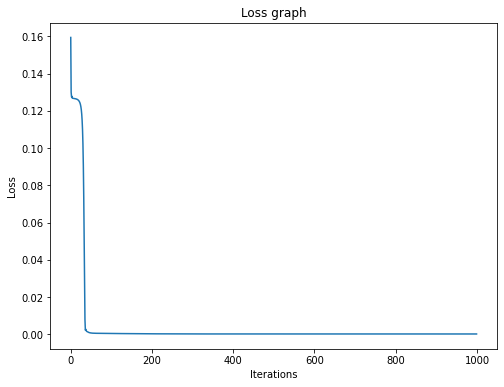

In [36]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model3.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

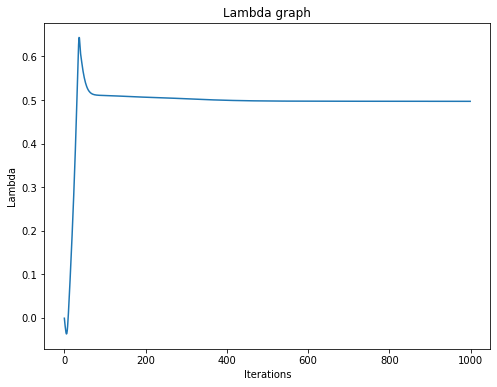

In [37]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model3.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [38]:
noise4 = 0.10 
u_train4 = u_train + noise4*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

In [39]:
model4 = PhysicsInformedNN3(X_u_train, u_train4, layers2, lb1, ub1 , q_t)
model4.train(10000)

Device mapping:

It: 0, Loss: 9.331e-01, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.39
It: 10, Loss: 5.769e-01, Lambda_1: 0.011, Lambda_2: 1.000000, Time: 0.01
It: 20, Loss: 3.449e-01, Lambda_1: 0.020, Lambda_2: 1.000000, Time: 0.01
It: 30, Loss: 2.139e-01, Lambda_1: 0.028, Lambda_2: 1.000000, Time: 0.01
It: 40, Loss: 1.529e-01, Lambda_1: 0.034, Lambda_2: 1.000000, Time: 0.01
It: 50, Loss: 1.316e-01, Lambda_1: 0.040, Lambda_2: 1.000000, Time: 0.01
It: 60, Loss: 1.272e-01, Lambda_1: 0.045, Lambda_2: 1.000000, Time: 0.01
It: 70, Loss: 1.272e-01, Lambda_1: 0.050, Lambda_2: 1.000000, Time: 0.01
It: 80, Loss: 1.274e-01, Lambda_1: 0.057, Lambda_2: 1.000000, Time: 0.01
It: 90, Loss: 1.272e-01, Lambda_1: 0.066, Lambda_2: 1.000000, Time: 0.01
It: 100, Loss: 1.271e-01, Lambda_1: 0.078, Lambda_2: 1.000000, Time: 0.01
It: 110, Loss: 1.270e-01, Lambda_1: 0.091, Lambda_2: 1.000000, Time: 0.01
It: 120, Loss: 1.270e-01, Lambda_1: 0.106, Lambda_2: 1.000000, Time: 0.01
It: 130, Loss: 1.270e-01, Lambda

It: 1160, Loss: 3.479e-03, Lambda_1: 0.623, Lambda_2: 1.000000, Time: 0.01
It: 1170, Loss: 3.356e-03, Lambda_1: 0.617, Lambda_2: 1.000000, Time: 0.01
It: 1180, Loss: 3.243e-03, Lambda_1: 0.611, Lambda_2: 1.000000, Time: 0.01
It: 1190, Loss: 3.139e-03, Lambda_1: 0.605, Lambda_2: 1.000000, Time: 0.01
It: 1200, Loss: 3.042e-03, Lambda_1: 0.600, Lambda_2: 1.000000, Time: 0.01
It: 1210, Loss: 2.954e-03, Lambda_1: 0.594, Lambda_2: 1.000000, Time: 0.01
It: 1220, Loss: 2.871e-03, Lambda_1: 0.590, Lambda_2: 1.000000, Time: 0.01
It: 1230, Loss: 2.795e-03, Lambda_1: 0.585, Lambda_2: 1.000000, Time: 0.01
It: 1240, Loss: 2.725e-03, Lambda_1: 0.581, Lambda_2: 1.000000, Time: 0.01
It: 1250, Loss: 2.659e-03, Lambda_1: 0.577, Lambda_2: 1.000000, Time: 0.01
It: 1260, Loss: 2.597e-03, Lambda_1: 0.574, Lambda_2: 1.000000, Time: 0.01
It: 1270, Loss: 2.539e-03, Lambda_1: 0.570, Lambda_2: 1.000000, Time: 0.01
It: 1280, Loss: 2.485e-03, Lambda_1: 0.567, Lambda_2: 1.000000, Time: 0.01
It: 1290, Loss: 2.433e-03

It: 2370, Loss: 7.563e-04, Lambda_1: 0.509, Lambda_2: 1.000000, Time: 0.01
It: 2380, Loss: 7.544e-04, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2390, Loss: 7.525e-04, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2400, Loss: 7.507e-04, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2410, Loss: 7.489e-04, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2420, Loss: 7.473e-04, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2430, Loss: 7.457e-04, Lambda_1: 0.508, Lambda_2: 1.000000, Time: 0.01
It: 2440, Loss: 7.442e-04, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2450, Loss: 7.427e-04, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2460, Loss: 7.413e-04, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2470, Loss: 7.399e-04, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2480, Loss: 7.386e-04, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2490, Loss: 7.374e-04, Lambda_1: 0.507, Lambda_2: 1.000000, Time: 0.01
It: 2500, Loss: 7.361e-04

It: 3580, Loss: 6.921e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3590, Loss: 6.919e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3600, Loss: 6.917e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3610, Loss: 6.916e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3620, Loss: 6.914e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3630, Loss: 6.912e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3640, Loss: 6.910e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3650, Loss: 6.908e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3660, Loss: 6.907e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3670, Loss: 6.905e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3680, Loss: 6.903e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3690, Loss: 6.901e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3700, Loss: 6.900e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 3710, Loss: 6.898e-04

It: 4730, Loss: 6.764e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4740, Loss: 6.763e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4750, Loss: 6.762e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4760, Loss: 6.761e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4770, Loss: 6.760e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4780, Loss: 6.759e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4790, Loss: 6.758e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4800, Loss: 6.757e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4810, Loss: 6.755e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4820, Loss: 6.754e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4830, Loss: 6.753e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4840, Loss: 6.752e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4850, Loss: 6.751e-04, Lambda_1: 0.503, Lambda_2: 1.000000, Time: 0.01
It: 4860, Loss: 6.750e-04

It: 5870, Loss: 6.658e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5880, Loss: 6.657e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5890, Loss: 6.660e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5900, Loss: 6.656e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5910, Loss: 6.655e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5920, Loss: 6.654e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5930, Loss: 6.654e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5940, Loss: 6.653e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5950, Loss: 6.652e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5960, Loss: 6.652e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5970, Loss: 6.651e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5980, Loss: 6.650e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 5990, Loss: 6.650e-04, Lambda_1: 0.502, Lambda_2: 1.000000, Time: 0.01
It: 6000, Loss: 6.649e-04

It: 6970, Loss: 6.602e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.03
It: 6980, Loss: 6.602e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.03
It: 6990, Loss: 6.602e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 7000, Loss: 6.601e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 7010, Loss: 6.601e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 7020, Loss: 6.601e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 7030, Loss: 6.600e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 7040, Loss: 6.600e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 7050, Loss: 6.600e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.03
It: 7060, Loss: 6.599e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 7070, Loss: 6.599e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 7080, Loss: 6.599e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 7090, Loss: 6.599e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.03
It: 7100, Loss: 6.618e-04

It: 8140, Loss: 6.570e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.03
It: 8150, Loss: 6.569e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 8160, Loss: 6.569e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.03
It: 8170, Loss: 6.569e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 8180, Loss: 6.569e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 8190, Loss: 6.569e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 8200, Loss: 6.568e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 8210, Loss: 6.568e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.03
It: 8220, Loss: 6.596e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.03
It: 8230, Loss: 6.595e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.03
It: 8240, Loss: 6.568e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.03
It: 8250, Loss: 6.568e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 8260, Loss: 6.568e-04, Lambda_1: 0.501, Lambda_2: 1.000000, Time: 0.02
It: 8270, Loss: 6.567e-04

It: 9260, Loss: 6.548e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9270, Loss: 6.548e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9280, Loss: 6.548e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9290, Loss: 6.548e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9300, Loss: 6.547e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9310, Loss: 6.547e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9320, Loss: 6.547e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9330, Loss: 6.547e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9340, Loss: 6.547e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9350, Loss: 6.547e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9360, Loss: 6.546e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9370, Loss: 6.546e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.02
It: 9380, Loss: 6.546e-04, Lambda_1: 0.500, Lambda_2: 1.000000, Time: 0.03
It: 9390, Loss: 6.546e-04

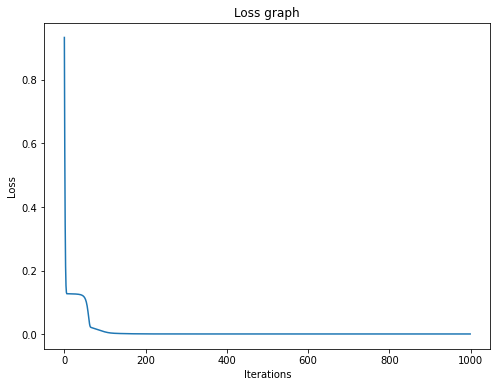

In [40]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model4.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

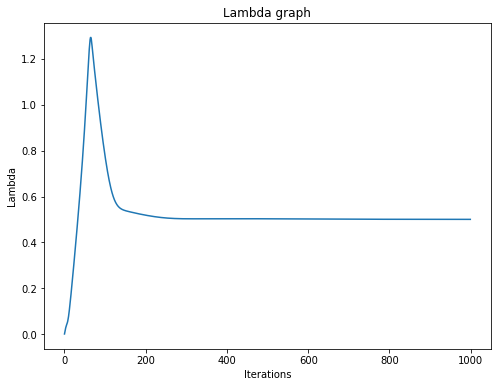

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model4.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()

In [43]:
noise5 = 0.25
u_train5 = u_train + noise5*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

In [44]:
model5 = PhysicsInformedNN3(X_u_train, u_train5, layers2, lb1, ub1 , q_t)
model5.train(10000)

Device mapping:

It: 0, Loss: 2.029e-01, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.35
It: 10, Loss: 1.305e-01, Lambda_1: 0.011, Lambda_2: 1.000000, Time: 0.02
It: 20, Loss: 1.299e-01, Lambda_1: 0.022, Lambda_2: 1.000000, Time: 0.01
It: 30, Loss: 1.283e-01, Lambda_1: 0.033, Lambda_2: 1.000000, Time: 0.01
It: 40, Loss: 1.266e-01, Lambda_1: 0.045, Lambda_2: 1.000000, Time: 0.01
It: 50, Loss: 1.268e-01, Lambda_1: 0.057, Lambda_2: 1.000000, Time: 0.01
It: 60, Loss: 1.264e-01, Lambda_1: 0.069, Lambda_2: 1.000000, Time: 0.01
It: 70, Loss: 1.264e-01, Lambda_1: 0.082, Lambda_2: 1.000000, Time: 0.01
It: 80, Loss: 1.264e-01, Lambda_1: 0.096, Lambda_2: 1.000000, Time: 0.01
It: 90, Loss: 1.264e-01, Lambda_1: 0.110, Lambda_2: 1.000000, Time: 0.01
It: 100, Loss: 1.263e-01, Lambda_1: 0.125, Lambda_2: 1.000000, Time: 0.01
It: 110, Loss: 1.263e-01, Lambda_1: 0.140, Lambda_2: 1.000000, Time: 0.01
It: 120, Loss: 1.262e-01, Lambda_1: 0.156, Lambda_2: 1.000000, Time: 0.01
It: 130, Loss: 1.262e-01, Lambda

It: 1240, Loss: 2.927e-03, Lambda_1: 0.515, Lambda_2: 1.000000, Time: 0.01
It: 1250, Loss: 2.920e-03, Lambda_1: 0.515, Lambda_2: 1.000000, Time: 0.01
It: 1260, Loss: 2.912e-03, Lambda_1: 0.514, Lambda_2: 1.000000, Time: 0.01
It: 1270, Loss: 2.905e-03, Lambda_1: 0.514, Lambda_2: 1.000000, Time: 0.01
It: 1280, Loss: 2.898e-03, Lambda_1: 0.514, Lambda_2: 1.000000, Time: 0.01
It: 1290, Loss: 2.891e-03, Lambda_1: 0.514, Lambda_2: 1.000000, Time: 0.01
It: 1300, Loss: 2.885e-03, Lambda_1: 0.513, Lambda_2: 1.000000, Time: 0.01
It: 1310, Loss: 2.878e-03, Lambda_1: 0.513, Lambda_2: 1.000000, Time: 0.01
It: 1320, Loss: 2.872e-03, Lambda_1: 0.513, Lambda_2: 1.000000, Time: 0.01
It: 1330, Loss: 2.866e-03, Lambda_1: 0.513, Lambda_2: 1.000000, Time: 0.01
It: 1340, Loss: 2.860e-03, Lambda_1: 0.512, Lambda_2: 1.000000, Time: 0.01
It: 1350, Loss: 2.854e-03, Lambda_1: 0.512, Lambda_2: 1.000000, Time: 0.01
It: 1360, Loss: 2.848e-03, Lambda_1: 0.512, Lambda_2: 1.000000, Time: 0.01
It: 1370, Loss: 2.842e-03

It: 2450, Loss: 2.511e-03, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2460, Loss: 2.509e-03, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2470, Loss: 2.507e-03, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2480, Loss: 2.506e-03, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2490, Loss: 2.504e-03, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2500, Loss: 2.502e-03, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2510, Loss: 2.501e-03, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2520, Loss: 2.499e-03, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2530, Loss: 2.498e-03, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2540, Loss: 2.496e-03, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2550, Loss: 2.495e-03, Lambda_1: 0.499, Lambda_2: 1.000000, Time: 0.01
It: 2560, Loss: 2.493e-03, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 2570, Loss: 2.492e-03, Lambda_1: 0.498, Lambda_2: 1.000000, Time: 0.01
It: 2580, Loss: 2.490e-03

It: 3640, Loss: 2.407e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3650, Loss: 2.407e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3660, Loss: 2.406e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3670, Loss: 2.405e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3680, Loss: 2.405e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3690, Loss: 2.404e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3700, Loss: 2.404e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3710, Loss: 2.404e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3720, Loss: 2.403e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3730, Loss: 2.403e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3740, Loss: 2.402e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3750, Loss: 2.402e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3760, Loss: 2.402e-03, Lambda_1: 0.491, Lambda_2: 1.000000, Time: 0.01
It: 3770, Loss: 2.401e-03

It: 4880, Loss: 2.368e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 4890, Loss: 2.372e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 4900, Loss: 2.368e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 4910, Loss: 2.369e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 4920, Loss: 2.369e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 4930, Loss: 2.368e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 4940, Loss: 2.367e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 4950, Loss: 2.366e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 4960, Loss: 2.366e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 4970, Loss: 2.366e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 4980, Loss: 2.366e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 4990, Loss: 2.366e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 5000, Loss: 2.366e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.01
It: 5010, Loss: 2.365e-03

It: 6050, Loss: 2.350e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 6060, Loss: 2.349e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.03
It: 6070, Loss: 2.349e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 6080, Loss: 2.349e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 6090, Loss: 2.349e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.03
It: 6100, Loss: 2.349e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 6110, Loss: 2.349e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 6120, Loss: 2.349e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 6130, Loss: 2.349e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 6140, Loss: 2.368e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.03
It: 6150, Loss: 2.368e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 6160, Loss: 2.354e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 6170, Loss: 2.350e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 6180, Loss: 2.348e-03

It: 7170, Loss: 2.337e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.03
It: 7180, Loss: 2.336e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.03
It: 7190, Loss: 2.336e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 7200, Loss: 2.336e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 7210, Loss: 2.336e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 7220, Loss: 2.336e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 7230, Loss: 2.336e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 7240, Loss: 2.336e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 7250, Loss: 2.336e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 7260, Loss: 2.336e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 7270, Loss: 2.335e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 7280, Loss: 2.335e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 7290, Loss: 2.346e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 7300, Loss: 2.351e-03

It: 8280, Loss: 2.325e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.03
It: 8290, Loss: 2.324e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 8300, Loss: 2.324e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 8310, Loss: 2.324e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 8320, Loss: 2.324e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 8330, Loss: 2.333e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 8340, Loss: 2.327e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 8350, Loss: 2.327e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 8360, Loss: 2.326e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.03
It: 8370, Loss: 2.324e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.03
It: 8380, Loss: 2.324e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 8390, Loss: 2.323e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 8400, Loss: 2.323e-03, Lambda_1: 0.488, Lambda_2: 1.000000, Time: 0.02
It: 8410, Loss: 2.323e-03

It: 9390, Loss: 2.313e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9400, Loss: 2.313e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9410, Loss: 2.313e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9420, Loss: 2.313e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9430, Loss: 2.313e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9440, Loss: 2.312e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9450, Loss: 2.312e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9460, Loss: 2.316e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9470, Loss: 2.314e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9480, Loss: 2.321e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.03
It: 9490, Loss: 2.315e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9500, Loss: 2.312e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9510, Loss: 2.312e-03, Lambda_1: 0.489, Lambda_2: 1.000000, Time: 0.02
It: 9520, Loss: 2.312e-03

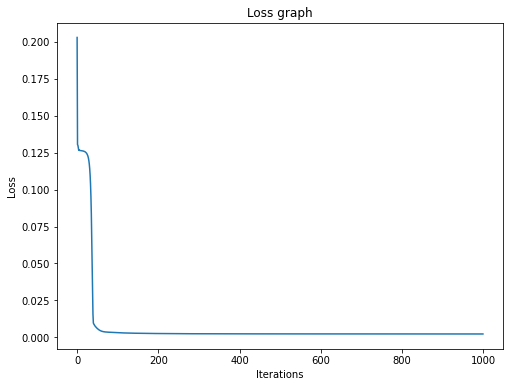

In [45]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model5.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

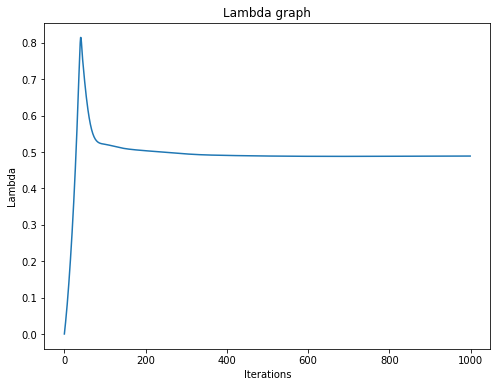

In [46]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model5.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()